# Part 0: Choose pretrained image classification model and images to be explained

## Imports

In [1]:
# gen
import os
import urllib.request
import requests
import time
import numpy as np
import cv2
import glob
from pathlib import Path
from tqdm import tqdm


# torch
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# sklearn
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# visualization
import matplotlib.pyplot as plt
from PIL import Image
from bs4 import BeautifulSoup



## Part 0: get the model

In [2]:
model = models.vgg16(pretrained=True)
model.eval()

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
image_dir = "images"

### Download images, imagenet classes

In [9]:
def download_unsplash_image(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        image_element = soup.find("meta", property="og:image")
        if image_element:
            image_url = image_element["content"]
            image_response = requests.get(image_url)
            if image_response.status_code == 200:
                timestamp = int(time.time())
                filename = f"images/image_{timestamp}.jpg"
                with open(filename, "wb") as f:
                    f.write(image_response.content)
                print(f"Image downloaded successfully as '{filename}'!")
            else:
                print("Failed to download the image.")
        else:
            print("Image URL not found on the page.")
    else:
        print("Failed to retrieve the page.")


In [8]:
Path(image_dir).mkdir(exist_ok=True, parents=True)
# Download a turtle image
turtle_image_url = 'https://unsplash.com/photos/L-2p8fapOA8'
download_unsplash_image(turtle_image_url)

# Download a dog image
dog_image_url = 'https://unsplash.com/photos/fv-4ZnKsAqg'
download_unsplash_image(dog_image_url)

# Download a basketball image
basketball_image_url = 'https://unsplash.com/photos/nM2WEy42Npg'
download_unsplash_image(basketball_image_url)


# Define the URL to download the ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# Define the filename to save the class labels
filename = "imagenet_classes.txt"

# Download the class labels
urllib.request.urlretrieve(url, filename)

print("ImageNet class labels downloaded successfully!")


Image downloaded successfully as 'images/image_1686811715.jpg'!
Image downloaded successfully as 'images/image_1686811716.jpg'!
Image downloaded successfully as 'images/image_1686811717.jpg'!
ImageNet class labels downloaded successfully!


In [5]:
with open("imagenet_classes.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

## Part 1: Choose pretrained image classification model

In [6]:
# visualize the images in the folder 'images', and put in the title the vgg prediction of the image

# Define the transformation for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def predict_image(pil_image, k):
    im = transform(pil_image)
    im = im.unsqueeze(0)
    with torch.no_grad():
        outputs = model(im)
    _, predicted_indices = torch.topk(outputs, k=k)
    predicted_indices = predicted_indices.squeeze().tolist()
    return predicted_indices

def read_image_and_inference_and_plot(image_path, plot=False):
    orig_im = Image.open(image_path)

    predicted_indices = predict_image(orig_im, k=3)
    print("Top predicted classes:")
    for index in predicted_indices:
        print(f"{class_names[index]}")

    if plot:
        fig = plt.figure(figsize=(8, 12))
        plt.imshow(orig_im)
        plt.title(f"{class_names[predicted_indices[0]]}")
        plt.show()

    top_1_class_name = class_names[predicted_indices[0]]
    
    return orig_im, predicted_indices[:3], top_1_class_name
    


#### Vosualize image and their predictions

Top predicted classes:
"loggerhead sea turtle",
"leatherback sea turtle",
"terrapin",


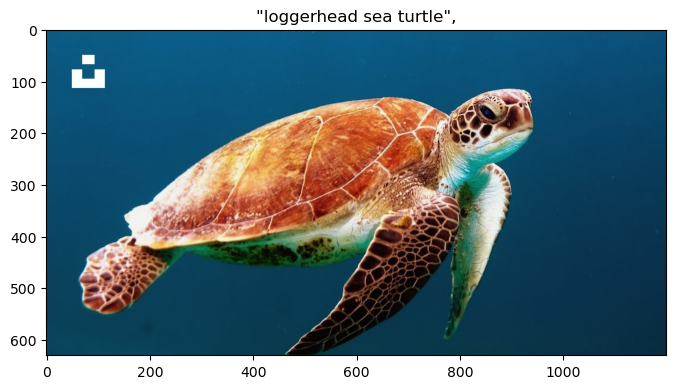

Top predicted classes:
"husky",
"Siberian Husky",
"Alaskan Malamute",


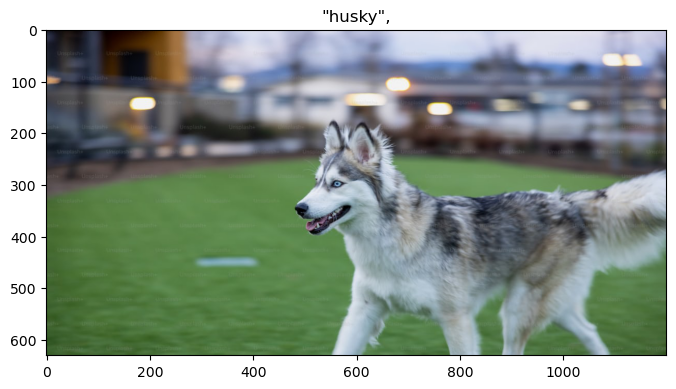

Top predicted classes:
"basketball",
"volleyball",
"clogs",


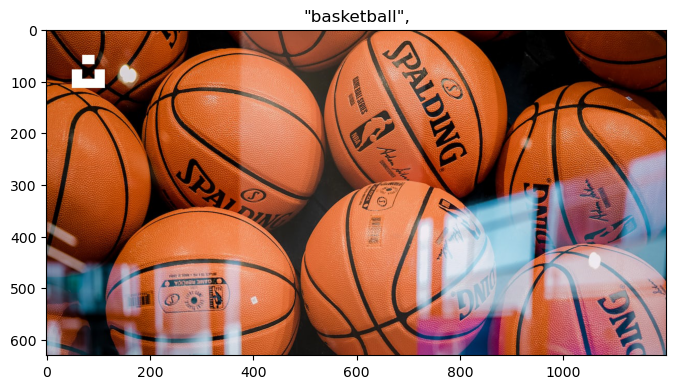

In [10]:
for image_path in Path(image_dir).iterdir():
    read_image_and_inference_and_plot(image_path, plot=True)


In [73]:
# def get_super_pixels(image, region_size):
#     image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
#     slic = cv2.ximgproc.createSuperpixelSLIC(image_lab, region_size=region_size)
#     slic.iterate(10)  # Number of iterations for refinement
#     labels = slic.getLabels()
#     mask = slic.getLabelContourMask()
#     result = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
#     result = cv2.addWeighted(image, 0.5, result, 0.5, 0)
#     return result, labels


def get_super_pixels(image, region_size):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    slic = cv2.ximgproc.createSuperpixelSLIC(image_lab, region_size=region_size)
    slic.iterate(10)  # Number of iterations for refinement
    labels = slic.getLabels()

    # Create a mask for the superpixel regions
    mask = np.zeros_like(image)
    for label in np.unique(labels):
        mask[labels == label] = image[labels == label]

    return mask, labels


There are 484 super pixels types


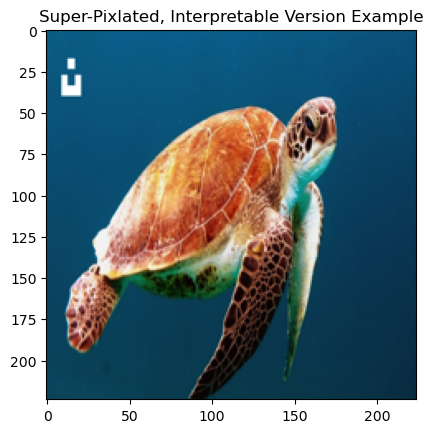

In [69]:
# example:
image_path = Path(glob.glob("images/*.jpg")[0])
image = np.array(Image.open(image_path).resize((224, 224)))
result, labels = get_super_pixels(image, region_size=10)
print(f"There are {len(np.unique(labels))} super pixels types")
plt.imshow(result)
plt.title("Super-Pixlated, Interpretable Version Example")
plt.show()


In [70]:
[class_names[i] for i in predict_image(Image.fromarray(result), k=10)]

['"loggerhead sea turtle",',
 '"leatherback sea turtle",',
 '"terrapin",',
 '"jellyfish",',
 '"dragonfly",',
 '"mud turtle",',
 '"isopod",',
 '"sea snake",',
 '"electric ray",',
 '"leafhopper",']

In [71]:
# using the labels, create a new image where each super pixel is colored with the average color of the super pixel
def get_average_color(image, labels):
    unique_labels = np.unique(labels)
    average_colors = []
    for label in unique_labels:
        indices = np.where(labels == label)
        average_color = np.mean(image[indices], axis=0)
        average_colors.append(average_color)
    return average_colors


def plot_image_with_average_colors(image, labels, average_colors):
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)
        image[indices] = average_colors[label]
    plt.imshow(image)
    plt.show()

There are 484 average colors


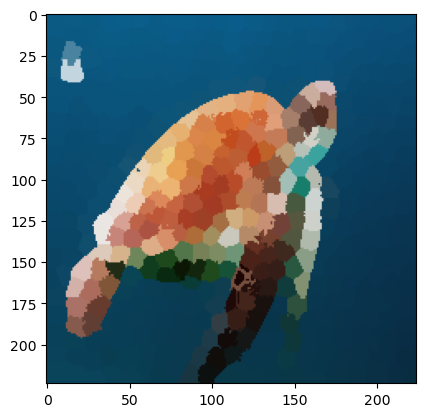

In [72]:
average_colors = get_average_color(image, labels)
print(f"There are {len(average_colors)} average colors")
plot_image_with_average_colors(image, labels, average_colors)


In [133]:
def gen_random_perturbations(img, one_hot_labels, perturbation_param=5, region_size=40, num_perturbations=500, plot=False):
    """
    Returns a list of perturbations, images with random superpixels removed, and the labels of the perturbations ready for training
    (1 row for each perturbation, with num_of_super_pixels columns - 1 if the superpixel is not removed, 0 if it is)
    """
    img = np.array(img)
    local_dataset = []
    local_dataset_labels = []
    orig_perturbed_instance, orig_perturbed_labels = get_super_pixels(img, region_size=region_size)
    num_of_super_pixels = len(np.unique(orig_perturbed_labels))
    for _ in tqdm(range(num_perturbations)):
        perturbation = np.random.randint(perturbation_param, size=num_of_super_pixels)

        # Apply perturbation to the interpretable instances == superpixels
        perturbed_instance, perturbed_labels = np.copy(orig_perturbed_instance), np.copy(orig_perturbed_labels)

        labels_for_training = np.zeros((1, num_of_super_pixels))

        for i in range(num_of_super_pixels):
            if perturbation[i] == 0:
                # Exclude the superpixel
                indices = np.where(one_hot_labels[:, :, i] == 1)
                perturbed_instance[indices] = 0  # Set the superpixel region to black
                perturbed_labels[indices] = 0  # No superpixel

        unique_labels = np.unique(perturbed_labels)
        for label in unique_labels:
            labels_for_training[:, label] = 1

        local_dataset.append(perturbed_instance)
        local_dataset_labels.append(labels_for_training)

    if plot:
        # Plot the last perturbed instance
        plt.imshow(perturbed_instance)
        plt.title("Perturbed instance")
        plt.show()

    return local_dataset, local_dataset_labels




In [28]:
# def gen_random_perturbations(img, one_hot_labels, num_perturbations = 500, plot=False):
#     """
#     returns a list of perturbations, images with random super pixels removed, and the labels of the perturbations ready for training
#       (1 row for each perturbation, with num_of_super_pixels columns - 1 if the super pixel is not removed, 0 if it is)
#     """
#     img = np.array(img)
#     local_dataset = []
#     local_dataset_labels = []
#     orig_perturbed_instance, orig_perturbed_labels = get_super_pixels(img, region_size=10)

#     num_of_super_pixels = len(np.unique(labels))
#     for _ in tqdm(range(num_perturbations)):
#         perturbation = np.random.randint(2, size=num_of_super_pixels)

#         # Apply perturbation to the interpretable instances == super pixels
#         perturbed_instance, perturbed_labels = np.copy(orig_perturbed_instance), np.copy(orig_perturbed_labels)
        
#         labels_for_training = np.zeros((1, num_of_super_pixels))

#         noise = np.random.randint(0, 256, size=perturbed_instance.shape)
#         # TODO: should we put here noise/gray/black pixels? tried all and all are not good (predictions on the super pixels images are not good)

#         for i in range(num_of_super_pixels):
#             if perturbation[i] == 0:
#                 # Exclude the superpixel
#                 indices = np.where(one_hot_labels[:, :, i] == 1)
#                 perturbed_instance[indices] = noise[indices]  # 128 for gray  # TODO: should we put here noise/gray/black pixels?
#                 perturbed_labels[indices] = 0  # no superpixel
        
#         # create a 2d, one-hot encoded labels, where the first column is super_pixel=0 dummy var, and the second column is super_pixel=1 dummy var, etc
#         # this should create 1 row with num_of_super_pixels columns
#         unique_labels = np.unique(perturbed_labels)
#         for label in unique_labels:
#             labels_for_training[: , label] = 1

#         local_dataset.append(perturbed_instance)
#         local_dataset_labels.append(labels_for_training)

#     if plot:
#         # plot the last perturbed_instance
#         plt.imshow(perturbed_instance)
#         plt.title("Perturbed instance")
#         plt.show()
#     return local_dataset, local_dataset_labels

In [29]:
def calculate_euclidean_distance(orig_img, perturbed_img):
    euclidean_distance = np.sqrt(np.sum((orig_img - perturbed_img) ** 2))
    return euclidean_distance


def calc_similarity(orig_img, perturbed_img):
    """proximity measure between the original image and the perturbed image"""
    SIGMA = 2000
    orig_img = np.array(orig_img)
    perturbed_img = np.array(perturbed_img)
    euc_distance = 1 - calculate_euclidean_distance(orig_img, perturbed_img)
    proximity_measure = np.e ** - ( (euc_distance / SIGMA) ** 2 )
    return proximity_measure

In [57]:
def fit_linear_model_and_return_important_features(data, labels, proximity_measures, num_of_super_pixels, verbose=False, n=3):
    """
    Fit a linear model with locally weighted loss (using 𝜋') and 𝐿! regularization on the
    generated dataset. Use K-Lasso for feature selection.
    uses pytorch
    """
    loss_fn = nn.MSELoss()
    lasso_loss = nn.L1Loss()
    model = nn.Linear(num_of_super_pixels, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    num_of_images = len(data)

    for epoch in range(30):
        for i in range(num_of_images):
            super_pixels_in_current_perm_one_hot_encoded = data[i]
            label = labels[i]
            proximity_measure = proximity_measures[i]
            image = torch.tensor(super_pixels_in_current_perm_one_hot_encoded, dtype=torch.float32).unsqueeze(0)
            label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
            proximity_measure = torch.tensor(proximity_measure, dtype=torch.float32)
            optimizer.zero_grad()
            output = model(image)
            loss = proximity_measure * loss_fn(output, label.unsqueeze(0))
            l1_regularization = lasso_loss(model.weight, torch.zeros_like(model.weight))
            loss += 0.1 * l1_regularization
            loss.backward()
            optimizer.step()
        if verbose:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # get the weights of the model
    weights = model.weight.detach().numpy().squeeze()

    # get the indices of the top 10 weights
    top_n_indices = np.argsort(abs(weights))[-n:]

    return top_n_indices

## Main loop

Top predicted classes:
"loggerhead sea turtle",
"leatherback sea turtle",
"terrapin",


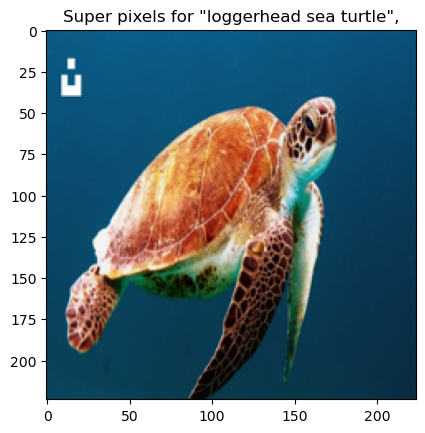

100%|██████████| 500/500 [00:54<00:00,  9.18it/s]


Predicting for class "loggerhead sea turtle",, 500 perturbations
Printing the first 5 perturbations results:
Predicted class: "loggerhead sea turtle",
Predicted class: "loggerhead sea turtle",
Predicted class: "scuba diver",
Predicted class: "loggerhead sea turtle",
Predicted class: "loggerhead sea turtle",


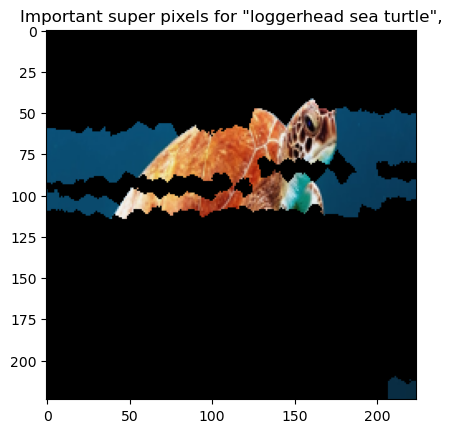

100%|██████████| 500/500 [00:51<00:00,  9.70it/s]


Predicting for class "leatherback sea turtle",, 500 perturbations
Printing the first 5 perturbations results:
Predicted class: "loggerhead sea turtle",
Predicted class: "loggerhead sea turtle",
Predicted class: "loggerhead sea turtle",
Predicted class: "jellyfish",
Predicted class: "lionfish",


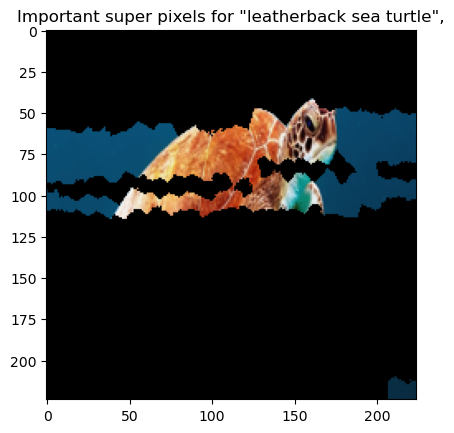

100%|██████████| 500/500 [00:57<00:00,  8.77it/s]


Predicting for class "terrapin",, 500 perturbations
Printing the first 5 perturbations results:
Predicted class: "lionfish",
Predicted class: "loggerhead sea turtle",
Predicted class: "jellyfish",
Predicted class: "loggerhead sea turtle",
Predicted class: "loggerhead sea turtle",


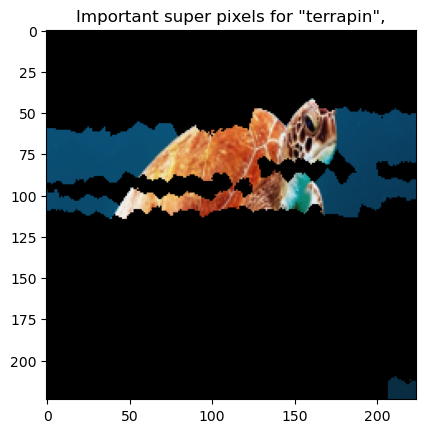

Top predicted classes:
"husky",
"Siberian Husky",
"Alaskan Malamute",


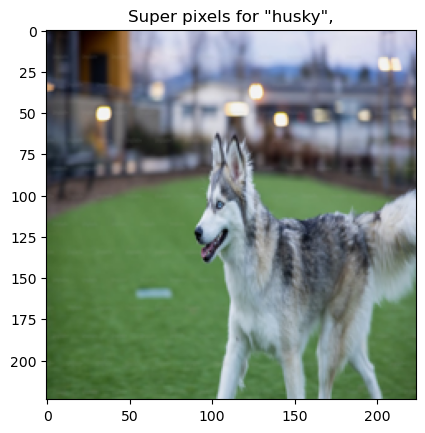

100%|██████████| 500/500 [00:51<00:00,  9.66it/s]


Predicting for class "husky",, 500 perturbations
Printing the first 5 perturbations results:
Predicted class: "husky",
Predicted class: "Border Collie",
Predicted class: "picket fence",
Predicted class: "husky",
Predicted class: "Border Collie",


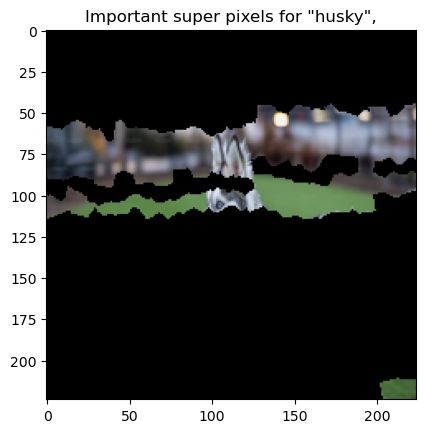

100%|██████████| 500/500 [03:32<00:00,  2.35it/s]  


Predicting for class "Siberian Husky",, 500 perturbations
Printing the first 5 perturbations results:
Predicted class: "picket fence",
Predicted class: "husky",
Predicted class: "husky",
Predicted class: "husky",
Predicted class: "Border Collie",


In [ ]:
region_size = 10
perturbation_param = 8
n_perturbations = 500

for image_path in Path(image_dir).iterdir():
    orig_img, top_3_classes, top_1_class_name = read_image_and_inference_and_plot(image_path, plot=False)

    # 4a
    # resize the image to 224x224
    orig_img = orig_img.resize((224, 224))
    image_as_array = np.array(orig_img)
    super_pixels, labels = get_super_pixels(image_as_array, region_size=region_size)
    plt.imshow(super_pixels)
    plt.title(f"Super pixels for {top_1_class_name}")
    plt.show()

    # 4b
    # Represent the interpretable instances as binary vectors. The entries of the vector correspond to inclusion/exclusion of the super pixels 𝑥$ ∈ {0,1}%!
    # one hot encode the labels
    num_of_super_pixels = len(np.unique(labels))
    one_hot_labels = np.zeros((labels.shape[0], labels.shape[1], num_of_super_pixels))
    for i in range(num_of_super_pixels):
      one_hot_labels[:, :, i] = (labels == i).astype(int)

    # 5a
    for class_index in top_3_classes:
    # i
        super_pixel_perturbations, super_pixel_labels = gen_random_perturbations_local(image_as_array, one_hot_labels, perturbation_param=perturbation_param, region_size=region_size, num_perturbations=n_perturbations)

        # ii
        # given the super_pixel_perturbations, and for each value !0, take the corresponding pixels from the original image
        bool_correct_current_class_predicted = []
        proximity_measures = []
        print(f"Predicting for class {class_names[class_index]}, {len(super_pixel_perturbations)} perturbations")
        print("Printing the first 5 perturbations results:")
        for i, super_pixel_perturbation in enumerate(super_pixel_perturbations):
            super_pixel_perturbation = super_pixel_perturbations[i]
            perturbed_image_pil = Image.fromarray(super_pixel_perturbation)
            class_predicted = predict_image(perturbed_image_pil, k=1)
            predictions.append(class_names[class_predicted])
            if i < 5:
                print(f"Predicted class: {class_names[class_predicted]}")
            bool_correct_current_class_predicted.append(class_predicted == class_index)  # explanation: for each class of the top 3 classes, 
            # we want to know if the perturbed image was predicted the same as the current class, 
            # and that's what we train on later on (the simple m odel)
            # iii - Calculate the similarity of the perturbed instance from the original image 𝜋'(𝑧)
            proximity_measure = calc_similarity(image_as_array, super_pixel_perturbation)
            proximity_measures.append(proximity_measure)

        proximity_measures = np.array(proximity_measures)
        bool_correct_current_class_predicted = np.array(bool_correct_current_class_predicted)
        # 5b
        # i - Fit a linear model with locally weighted loss (using 𝜋') and 𝐿! regularization on the generated dataset. Use K-Lasso for feature selection.
        important_features = fit_linear_model_and_return_important_features(np.array(super_pixel_labels).squeeze(), bool_correct_current_class_predicted, proximity_measures, num_of_super_pixels, n=100)

        # ii - Find and present the set of important features (super-pixels/tiles) for the prediction 𝑓(𝑥)
        # get the super pixels of the important features
        important_features_indices = np.isin(labels, important_features)

        # get the super pixels of the important features
        important_super_pixels = np.zeros_like(image_as_array)
        important_super_pixels[important_features_indices] = image_as_array[important_features_indices]

        # plot the important super pixels
        plt.imshow(important_super_pixels)
        plt.title(f"Important super pixels for {class_names[class_index]}")
        plt.show()






##### IMPORTANT TODO: why the predictions on the erased images are so far away from the truth? I feel like that is the reason the 'important super pixels' selected are not good

#### From here on, it's just the same code as in the main loop, for debugging/understanding

In [74]:
image_path = glob.glob(os.path.join(image_dir, "*.jpg"))[0]
orig_img, top_3_classes, top_1_class_name = read_image_and_inference_and_plot(image_path, plot=False)
top_1_class_name

Top predicted classes:
"loggerhead sea turtle",
"leatherback sea turtle",
"terrapin",


'"loggerhead sea turtle",'

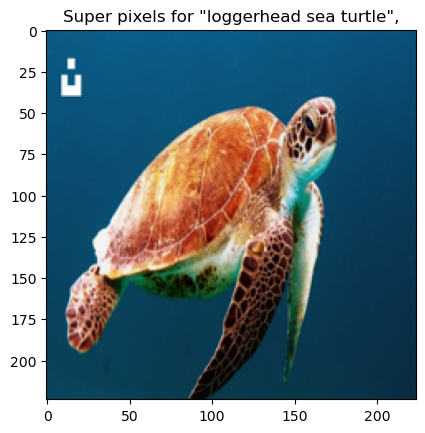

In [75]:

# 4a
# resize the image to 224x224
orig_img = orig_img.resize((224, 224))
orig_img_as_array = np.array(orig_img)
super_pixels, labels = get_super_pixels(orig_img_as_array, region_size=10)
plt.imshow(super_pixels)
plt.title(f"Super pixels for {top_1_class_name}")
plt.show()


In [76]:

# 4b
# Represent the interpretable instances as binary vectors. The entries of the vector correspond to inclusion/exclusion of the super pixels 𝑥$ ∈ {0,1}%!
# one hot encode the labels
num_of_super_pixels = len(np.unique(labels))
one_hot_labels = np.zeros((labels.shape[0], labels.shape[1], num_of_super_pixels))
for i in range(num_of_super_pixels):
    one_hot_labels[:, :, i] = (labels == i).astype(int)

print(one_hot_labels.shape)
print(np.sum(one_hot_labels[0]))

(224, 224, 484)
224.0


In [190]:
super_pixel_perturbations, super_pixel_labels = gen_random_perturbations_local(orig_img, one_hot_labels, perturbation_param=8, region_size=10, num_perturbations=500, plot=False) # plots the last perturbation
# super_pixel_perturbations[0].shape

100%|██████████| 500/500 [00:12<00:00, 39.13it/s]


In [191]:
len(super_pixel_perturbations)

500

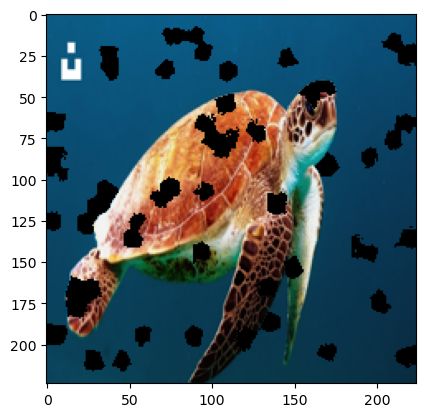

In [192]:
plt.imshow(super_pixel_perturbations[1])

  0%|          | 0/500 [00:00<?, ?it/s]

Predicted class: "lionfish",


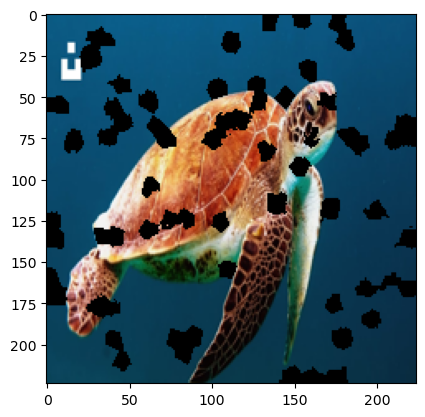

 20%|██        | 100/500 [00:32<02:19,  2.87it/s]

Predicted class: "loggerhead sea turtle",


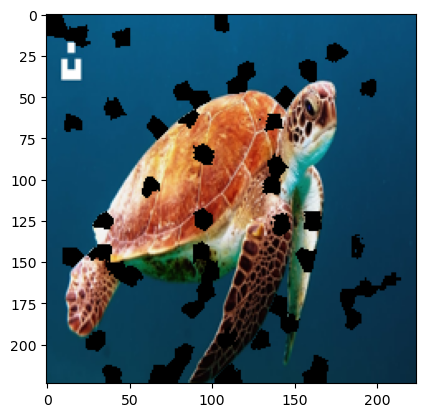

 40%|████      | 200/500 [01:07<01:43,  2.90it/s]

Predicted class: "jellyfish",


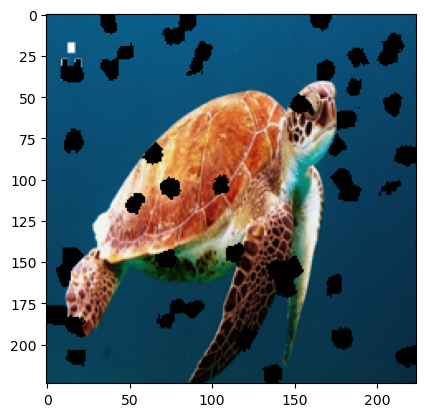

 60%|██████    | 300/500 [01:44<01:21,  2.45it/s]

Predicted class: "jellyfish",


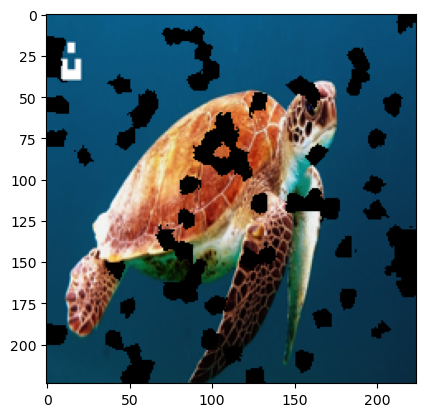

 80%|████████  | 400/500 [02:22<00:35,  2.79it/s]

Predicted class: "loggerhead sea turtle",


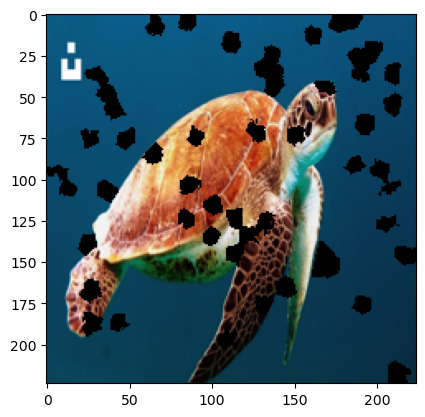

100%|██████████| 500/500 [03:01<00:00,  2.75it/s]


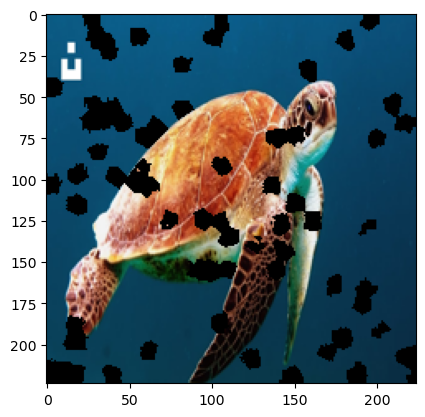

[0.58646458797007,
 0.6353544338537538,
 0.6770898552825884,
 0.6465187485379232,
 0.5933970281203264,
 0.6141055410518195,
 0.6056992677285777,
 0.6617999155633649,
 0.6240217593765182,
 0.6412552656959656,
 0.6194639798769629,
 0.630152329505399,
 0.6328536395994361,
 0.5893153628069513,
 0.6515489667727722,
 0.6048166679809578,
 0.6430898574570661,
 0.596503927768963,
 0.5536555167847369,
 0.5891078084128406,
 0.6640378396837553,
 0.671013775273657,
 0.6134379283621506,
 0.623686214220325,
 0.63381638803995,
 0.6055676353940159,
 0.6222040597497372,
 0.6195063839731902,
 0.5709450208667557,
 0.5997162223102277,
 0.6355433396266941,
 0.5629993487925959,
 0.5823918727456383,
 0.6452877808531562,
 0.5354120676897072,
 0.5662248118802141,
 0.64924847406616,
 0.5809281025049515,
 0.6248945841181488,
 0.5854164714894191,
 0.6337592310094022,
 0.557623511745262,
 0.6647403800559409,
 0.6128197233741046,
 0.550067308067762,
 0.5664243090015536,
 0.656141466597629,
 0.5680582959038571,
 0.63

In [193]:
predictions = []
# ii
bool_correct_current_class_predicted = []
proximity_measures = []
class_index = top_3_classes[0]


for i in tqdm(range(len(super_pixel_perturbations))):
    super_pixel_perturbation = super_pixel_perturbations[i]
    perturbed_image_pil = Image.fromarray(super_pixel_perturbation)
    class_predicted = predict_image(perturbed_image_pil, k=1)
    predictions.append(class_names[class_predicted])
    if i  % 100 == 0:
        print(f"Predicted class: {class_names[class_predicted]}")
        plt.imshow(perturbed_image_pil)
        plt.show()

    bool_correct_current_class_predicted.append(class_predicted == class_index)  # explanation: for each class of the top 3 classes,
    # we want to know if the perturbed image was predicted the same as the current class,
    # and that's what we train on later on (the simple model)
    # iii - Calculate the similarity of the perturbed instance from the original image 𝜋'(𝑧)
    proximity_measure = calc_similarity(orig_img, perturbed_image_pil)
    proximity_measures.append(proximity_measure)

plt.imshow(super_pixel_perturbation)
plt.show()

proximity_measures

In [194]:
proximity_measures = np.array(proximity_measures)
bool_correct_current_class_predicted = np.array(bool_correct_current_class_predicted)
bool_correct_current_class_predicted.sum() / len(bool_correct_current_class_predicted)

0.578

In [211]:
bool_correct_current_class_predicted

array([False, False,  True,  True,  True])

In [196]:
# predictions

In [210]:

# fit a linear model with locally weighted loss (using 𝜋') and 𝐿! regularization on the generated dataset
important_features = fit_linear_model_and_return_important_features(np.array(super_pixel_labels).squeeze(), bool_correct_current_class_predicted, proximity_measures, num_of_super_pixels, n=100)
important_features  # out of the {num_of_super_pixels} super pixels, these are the important ones


IndexError: index 5 is out of bounds for axis 0 with size 5

In [201]:

# ii - Find and present the set of important features (super-pixels/tiles) for the prediction 𝑓(𝑥)

important_features_indices = np.isin(labels, important_features)
important_features_indices.shape


(224, 224)

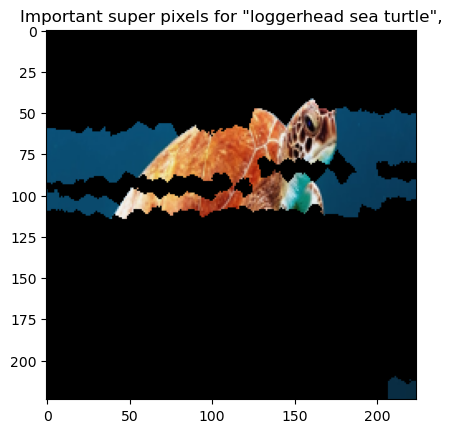

In [202]:

# get the super pixels of the important features
important_super_pixels = np.zeros_like(image)
important_super_pixels[important_features_indices] = orig_img_as_array[important_features_indices]

# plot the important super pixels
plt.imshow(important_super_pixels)
plt.title(f"Important super pixels for {class_names[class_index]}")
plt.show()


    
  
